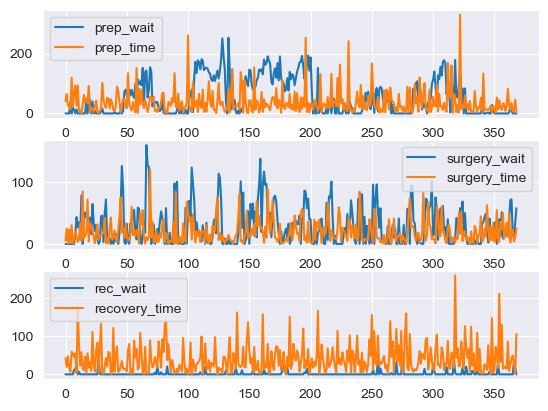

In [11]:
import simpy
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

times = pd.DataFrame(columns = ["name","prep_time","surgery_time","recovery_time","total_time","prep_wait","surgery_wait","rec_wait"])
def patient_stream(env):
    patients = 0
    while True:
        prep = stats.expon(scale = 40).rvs()
        op = stats.expon(scale = 20).rvs()
        recovery = stats.expon(scale = 40).rvs()
        patients +=1
        interarrival_time = stats.expon(scale = 25).rvs()
        #print(interarrival_time)
        yield env.timeout(interarrival_time)
        env.process(patient(env,f"Patient{patients} ",prep,op,recovery))

def patient(env,name,prep_time,surgery_time,recovery_time):
    arrival = env.now
    prep_req = preparation.request()
    start_prep_wait = env.now
    yield prep_req
    end_prep_wait = env.now
    yield env.timeout(prep_time)

    or_req=operating_room.request()
    start_surgery_wait = env.now
    yield or_req
    preparation.release(prep_req)
    end_surgery_wait = env.now
    yield env.timeout(surgery_time)

    recovery_req=recovery.request()
    start_rec_wait = env.now
    yield recovery_req
    operating_room.release(or_req)
    end_rec_wait = env.now
    yield env.timeout(recovery_time)
    recovery.release(recovery_req)

    total_time = env.now - arrival
    rec_wait = end_rec_wait - start_rec_wait
    surgery_wait = end_surgery_wait - start_surgery_wait
    prep_wait = end_prep_wait - start_prep_wait
    times.loc[len(times)] = [name,prep_time,surgery_time,recovery_time, total_time,prep_wait,surgery_wait,rec_wait]

env = simpy.Environment()
preparation = simpy.Resource(env,capacity = 3)
operating_room = simpy.Resource(env,capacity = 1)
recovery = simpy.Resource(env,capacity = 3)
env.process(patient_stream(env))

env.run(until=10000)


fig,axs=plt.subplots(nrows=3)
for wait,real,ax in zip(["prep_wait","surgery_wait","rec_wait"],["prep_time","surgery_time","recovery_time"],axs.ravel()):
    ax.plot(times[wait],label=wait)
    ax.plot(times[real],label=real)
    ax.legend()


In [12]:
import matplotlib.pyplot as plt
from run_sim import run_sim
from config import CONFIG
from statistics import mean

result = run_sim(CONFIG)
m = result["metrics"]

print(f"Patients completed: {m['completed']}")

if m["patient_times"]:
    avg_total = mean(pt["total_time"] for pt in m["patient_times"])
    avg_prep_wait = mean(pt["prep_wait"] for pt in m["patient_times"])
    avg_or_wait = mean(pt["or_wait"] for pt in m["patient_times"])
    avg_rec_wait = mean(pt["rec_wait"] for pt in m["patient_times"])
    print(f"Avg total time in system: {avg_total:.1f} min")
    print(f"Avg prep wait: {avg_prep_wait:.1f} min")
    print(f"Avg OR wait: {avg_or_wait:.1f} min")
    print(f"Avg recovery wait: {avg_rec_wait:.1f} min")

if m["or_q"]:
    avg_or_q = mean(v for _, v in m["or_q"])
    print(f"Avg OR queue length: {avg_or_q:.2f}")

if m["or_util"]:
    avg_or_util = mean(v for _, v in m["or_util"])
    print(f"Avg OR utilization: {avg_or_util:.1%}")

Patients completed: 26
Avg total time in system: 527.5 min
Avg prep wait: 14.8 min
Avg OR wait: 414.6 min
Avg recovery wait: 0.0 min
Avg OR queue length: 19.91
Avg OR utilization: 97.6%


# OR queue length over time

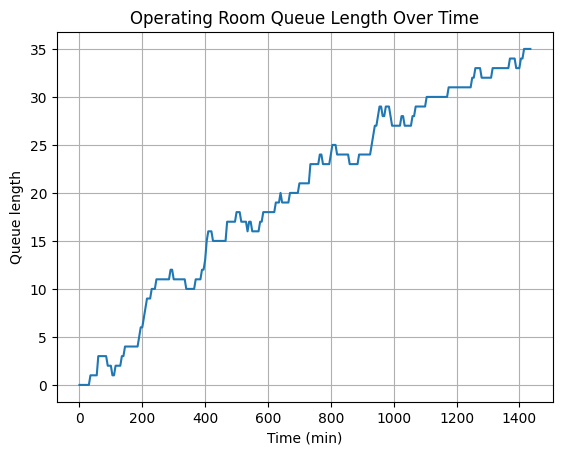

In [7]:
times, or_q = zip(*m["or_q"])
plt.figure()
plt.plot(times, or_q)
plt.title("Operating Room Queue Length Over Time")
plt.xlabel("Time (min)")
plt.ylabel("Queue length")
plt.grid(True)
plt.show()



# OR utilisation over time

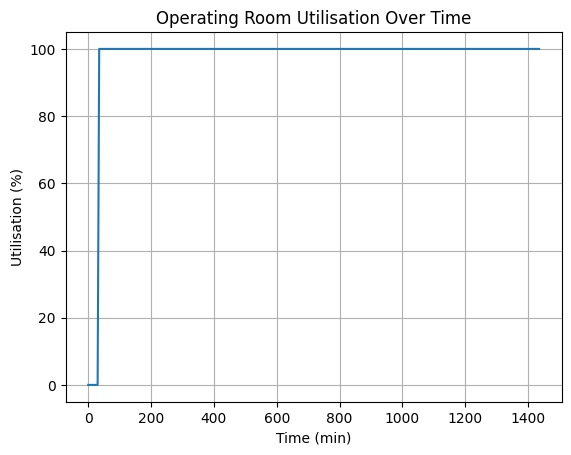

In [6]:
times, or_util = zip(*m["or_util"])
plt.figure()
plt.plot(times, [u * 100 for u in or_util])
plt.title("Operating Room Utilisation Over Time")
plt.xlabel("Time (min)")
plt.ylabel("Utilisation (%)")
plt.grid(True)
plt.show()

# Queue comparison

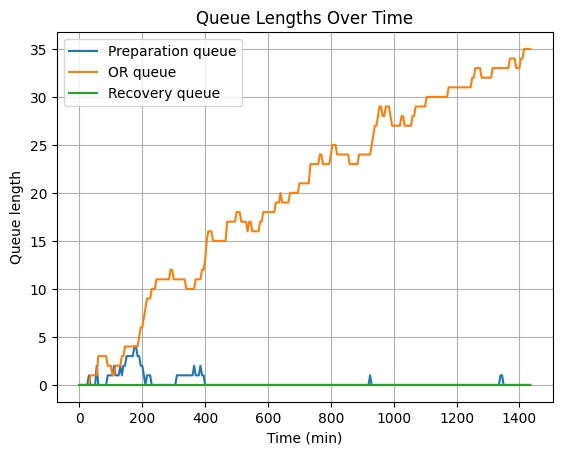

In [4]:
plt.figure()
plt.plot(*zip(*m["prep_q"]), label="Preparation queue")
plt.plot(*zip(*m["or_q"]), label="OR queue")
plt.plot(*zip(*m["rec_q"]), label="Recovery queue")
plt.legend()
plt.title("Queue Lengths Over Time")
plt.xlabel("Time (min)")
plt.ylabel("Queue length")
plt.grid(True)
plt.show()

# Histogram of total time in system

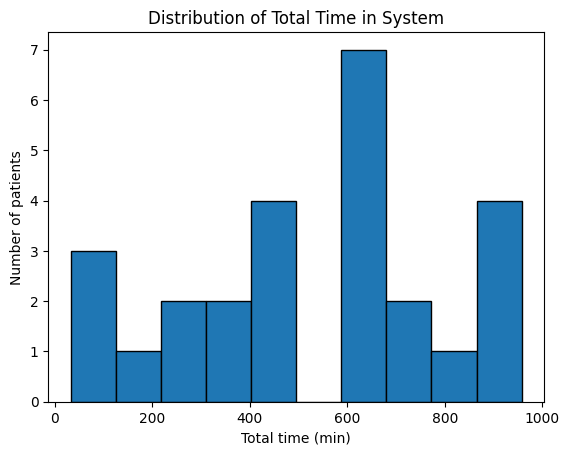

In [5]:
total_times = [pt["total_time"] for pt in m["patient_times"]]
plt.figure()
plt.hist(total_times, bins=10, edgecolor="black")
plt.title("Distribution of Total Time in System")
plt.xlabel("Total time (min)")
plt.ylabel("Number of patients")
plt.show()